In [ ]:
# Nos conectamos a nuestro conjunto de datos

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [ ]:
# Abrimos nuestro dataset de train para prepararlo
df_train = pd.read_csv('./drive/MyDrive/deep-learning-rogelio/trainAttrX.csv', sep=';', decimal='.')
df_train.shape

(750, 22)

In [ ]:
df_train.head(10)

,Host Listings Count,Host Total Listings Count,Accommodates,Bathrooms,Bedrooms,Beds,Price,Weekly Price,Monthly Price,Security Deposit,...,Extra People,Availability 365,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Location,Calculated host listings count,Host Since in Days,Entire home/apt,Private room
0,2.0,2.0,2,1.0,1.0,1.0,23.0,NaN,NaN,NaN,...,10,72,93.0,9.0,9.0,9.0,2,153,0,1
1,9.0,9.0,2,2.0,1.0,1.0,30.0,NaN,NaN,NaN,...,0,91,91.0,10.0,9.0,10.0,9,2028,0,1
2,1.0,1.0,2,1.0,1.0,1.0,33.0,185.0,740.0,NaN,...,0,248,98.0,10.0,10.0,10.0,1,1367,0,1
3,1.0,1.0,8,3.5,4.0,6.0,180.0,NaN,NaN,NaN,...,0,18,91.0,9.0,9.0,9.0,1,1099,1,0
4,1.0,1.0,2,1.0,1.0,2.0,27.0,NaN,NaN,NaN,...,19,311,84.0,8.0,9.0,9.0,1,272,0,1
5,2.0,2.0,5,1.0,3.0,4.0,98.0,NaN,NaN,NaN,...,0,277,92.0,10.0,10.0,10.0,2,596,1,0
6,1.0,1.0,5,1.0,3.0,3.0,80.0,NaN,NaN,NaN,...,30,331,92.0,9.0,9.0,10.0,1,2418,1,0
7,1.0,1.0,6,2.0,2.0,3.0,75.0,NaN,1800.0,150.0,...,10,258,95.0,10.0,9.0,10.0,1,1768,1,0
8,1.0,1.0,2,1.5,1.0,1.0,40.0,NaN,NaN,91.0,...,30,347,95.0,9.0,9.0,9.0,1,830,0,1
9,1.0,1.0,2,1.0,1.0,1.0,25.0,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,1,987,0,1


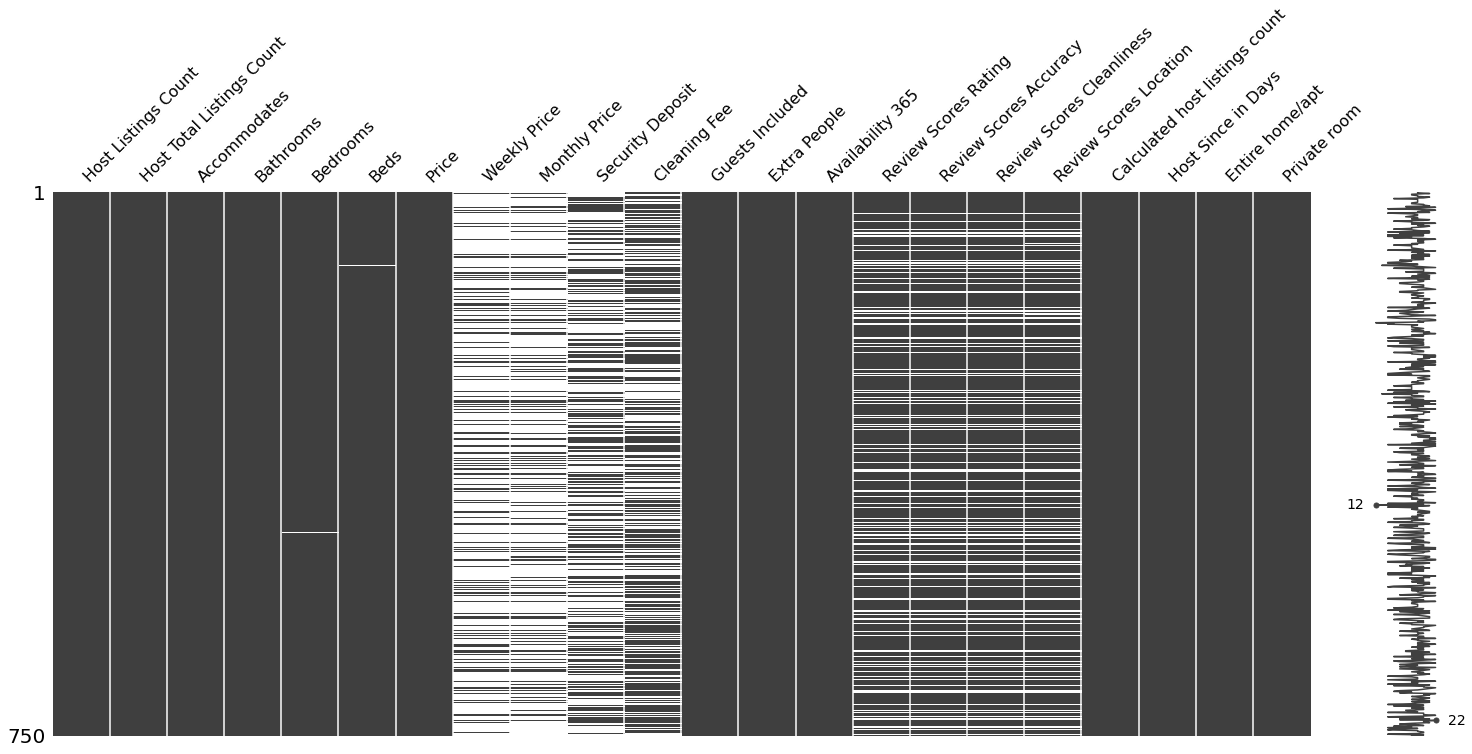

In [ ]:
# Observamos el missing data
import missingno as msno

msno.matrix(df_train)

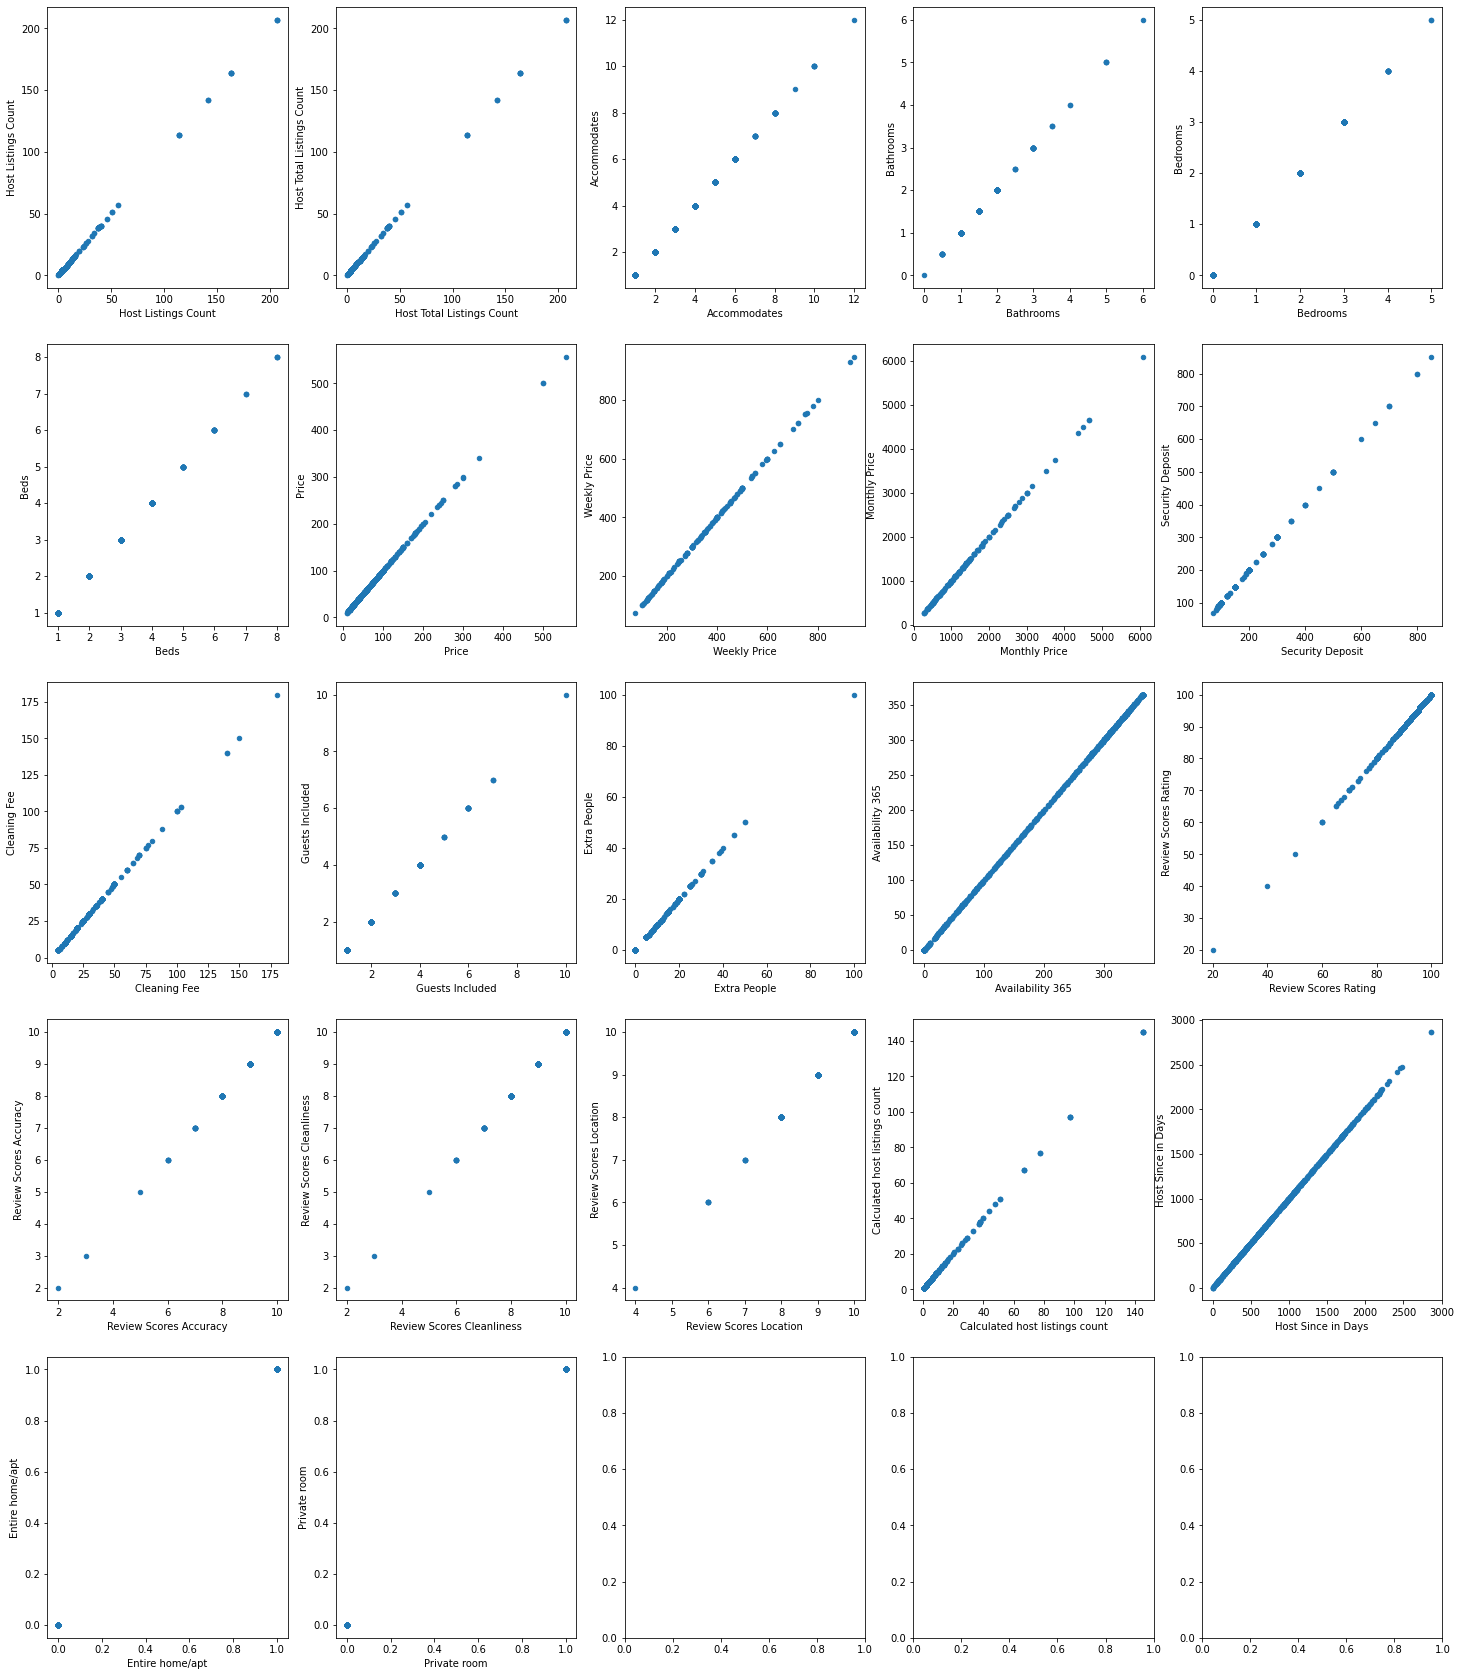

In [ ]:
# Vamos a graficar cada columna en scatter para ver si hay outliers, lo vamos a mostrar en subplot
fig, ax = plt.subplots(5, 5, figsize=(25, 30))
for variable, subplot in zip(df_train.columns, ax.flatten()):
    df_train.plot(kind='scatter', x=variable, y=variable, ax=subplot)

In [ ]:

# Añadir al objeto outliers las filas del dataframe que, basados en la columna Montly Price, se consideran outliers
outliers = df_train[df_train['Monthly Price'] > 7000]
print(outliers.index.to_list())
# Obtenemos las filas del dataframe que, basados en la columna Cleaning Fee, se consideran outliers
outliers = outliers.append(df_train[df_train['Cleaning Fee'] > 299])
# Obtenemos las filas del dataframe que, basados en la columna Extra People, se consideran outliers
outliers = outliers.append(df_train[df_train['Extra People'] > 99])
outliers

[]


,Host Listings Count,Host Total Listings Count,Accommodates,Bathrooms,Bedrooms,Beds,Price,Weekly Price,Monthly Price,Security Deposit,...,Extra People,Availability 365,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Location,Calculated host listings count,Host Since in Days,Entire home/apt,Private room
49,1.0,1.0,2,1.0,1.0,2.0,59.0,NaN,NaN,NaN,...,100,57,100.0,10.0,10.0,10.0,1,328,0,1


In [ ]:
# Eliminamos los outliers, no son muchas filas
# df_train = df_train.drop(outliers.index.to_list())

# Reemplazamos el valor con la media
df_train.loc[outliers.index.to_list(), 'Extra People'] = df_train['Extra People'].mean()

In [ ]:
df_train.shape

(750, 22)

## Vamos ahora a hacer la reconstrucción de los datos faltantes con knn como lo hicimos con machine learning

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
# Hacemos loo mismoo para las siguientes variables
# Obtenemos en una lista las variables que queremos imputar a partir de la variable corr
# lista_columnas = corr['Square Feet'].sort_values(ascending=False).index.tolist()
# Vamos a obtener la lista de los porcentajes de valores faltantes ordenados de menor a mayor, vamos a ir recuperando datos de forma escalonada
lista_columnas = df_train.isnull().sum().sort_values(ascending=True).index.tolist()
# Vamos a recorrer la lista y conforme lo hagamos vamos a ir imputando los valores faltantes
corr = np.abs(df_train.corr())
# Hacemos una copia de nuestro dataframe
df_for_imputation = df_train.copy()
for columna in lista_columnas:
    columnas_relacionadas = corr[columna].sort_values(ascending=False).index.tolist()
    # Tomamos las columnas que tienen una correlación mayor a .39
    columnas_relacionadas = [x for x in columnas_relacionadas if corr[columna][x] > .29]
    # Tomamos las columnas que no son la columna que estamos analizando
    # columnas_relacionadas = [x for x in columnas_relacionadas if x != columna]
    print(f'Evaluando la columna {columna} con las variables relacionadas: {columnas_relacionadas}')
    # Creamos un dataframe con las variables que queremos imputar
    df_knn = df_for_imputation.filter(columnas_relacionadas, axis=1).copy()
    # Normalizamos los datos
    df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)
    # Define KNN imputer and fill missing values
    knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)
    # Denormalize the data
    df_knn_imputed = pd.DataFrame(scaler.inverse_transform(df_knn_imputed), columns = df_knn_imputed.columns)
    # Asignamos los valores imputados a la variable original
    df_for_imputation[columna] = df_knn_imputed[columna]

Evaluando la columna Host Listings Count con las variables relacionadas: ['Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count']
Evaluando la columna Host Since in Days con las variables relacionadas: ['Host Since in Days', 'Weekly Price']
Evaluando la columna Calculated host listings count con las variables relacionadas: ['Calculated host listings count', 'Host Listings Count', 'Host Total Listings Count', 'Cleaning Fee']
Evaluando la columna Availability 365 con las variables relacionadas: ['Availability 365']
Evaluando la columna Extra People con las variables relacionadas: ['Extra People', 'Guests Included', 'Accommodates', 'Monthly Price']
Evaluando la columna Guests Included con las variables relacionadas: ['Guests Included', 'Accommodates', 'Monthly Price', 'Beds', 'Extra People', 'Bedrooms', 'Price', 'Weekly Price', 'Entire home/apt', 'Private room', 'Cleaning Fee']
Evaluando la columna Entire home/apt con las variables relacionadas: ['Entire home

<ipython-input-53-b6cc8861aa78>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


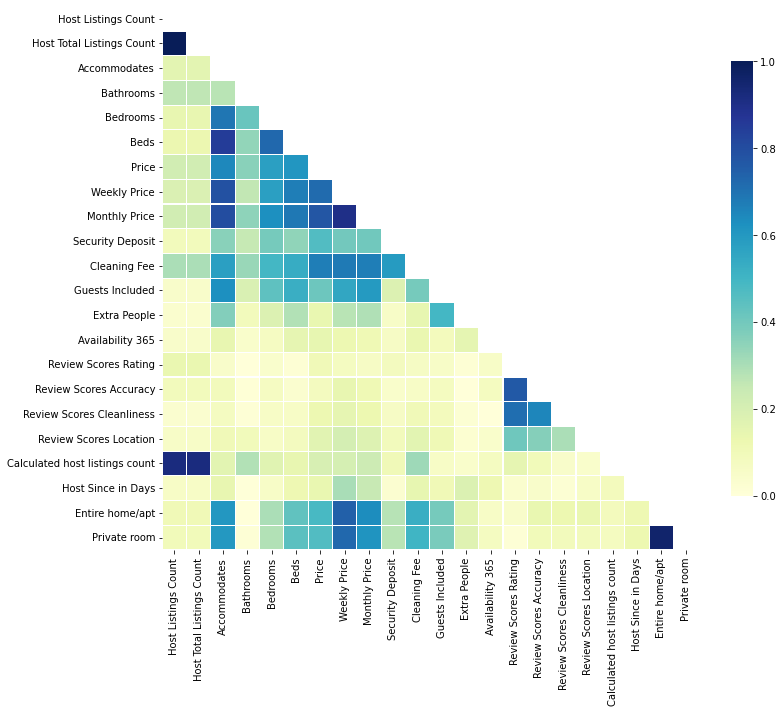

In [ ]:
# Comprobamos la correlación
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_for_imputation.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [ ]:
import pandas as pd

def detect_rows_with_all_zero_values(df):
    # Find the rows with all zero values
    rows_with_zero = (df == 0).all(axis=1)
    # Find the indices of those rows
    indices = np.where(rows_with_zero == True)[0]
    return indices

indices = detect_rows_with_all_zero_values(df_for_imputation)
indices

array([], dtype=int64)

In [ ]:
def detect_rows_with_all_missing_values(df):
    # Find the rows with all missing values
    rows_with_missing = df.isnull().all(axis=1)
    # Find the indices of those rows
    indices = np.where(rows_with_missing == True)[0]
    return indices

indices = detect_rows_with_all_missing_values(df_for_imputation)
indices

array([], dtype=int64)

In [ ]:
df_for_imputation[df_for_imputation.isnull().any(axis=1)]

,Host Listings Count,Host Total Listings Count,Accommodates,Bathrooms,Bedrooms,Beds,Price,Weekly Price,Monthly Price,Security Deposit,...,Extra People,Availability 365,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Location,Calculated host listings count,Host Since in Days,Entire home/apt,Private room


In [ ]:
df_for_imputation.shape

(750, 22)

In [ ]:
# comparado con el anterior se pierde correlación, pero ya tenemos todos los datos completos
#train_data = df_for_imputation.dropna()
df_for_imputation.isna().mean()*100


Host Listings Count               0.0
Host Total Listings Count         0.0
Accommodates                      0.0
Bathrooms                         0.0
Bedrooms                          0.0
Beds                              0.0
Price                             0.0
Weekly Price                      0.0
Monthly Price                     0.0
Security Deposit                  0.0
Cleaning Fee                      0.0
Guests Included                   0.0
Extra People                      0.0
Availability 365                  0.0
Review Scores Rating              0.0
Review Scores Accuracy            0.0
Review Scores Cleanliness         0.0
Review Scores Location            0.0
Calculated host listings count    0.0
Host Since in Days                0.0
Entire home/apt                   0.0
Private room                      0.0
dtype: float64

In [ ]:
# Guardamos y copiamos a nuestro drive
df_for_imputation.to_csv('./train_data.csv', sep=';', decimal='.', index=False)
!cp train_data.csv /content/drive/My\ Drive/deep-learning-rogelio/train_data.csv